In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# GPU 优先
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"训练样本数: {len(train_dataset)}, 测试样本数: {len(test_dataset)}")

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:04<00:00, 2.05MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 138kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.54MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.79MB/s]

训练样本数: 60000, 测试样本数: 10000


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # ==== Encoder: 28x28 -> latent μ,σ ====
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 28->14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 14->7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu     = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
        
        # ==== Decoder: latent -> 28x28 ====
        self.fc_decode = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # 7->14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),  # 14->28
            nn.Sigmoid()  # 输出 0~1
        )
    # 输出高斯分布
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar
    # 重参数化
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # 采样 z
    
    def decode(self, z):
        h = self.fc_decode(z).view(-1, 64, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [5]:
def vae_loss(x_hat, x, mu, logvar):
    # 重建损失（像素级别）
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    
    # KL 散度（让 q(z|x) ~ N(0,1)）
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


In [9]:
vae = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 5
vae.train()
for epoch in range(1, num_epochs+1):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        
        x_hat, mu, logvar = vae(x)
        loss = vae_loss(x_hat, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_dataset):.4f}")


Epoch 1, Loss: 149.5679
Epoch 2, Loss: 113.5407
Epoch 3, Loss: 109.2657
Epoch 4, Loss: 107.2549
Epoch 5, Loss: 106.0543


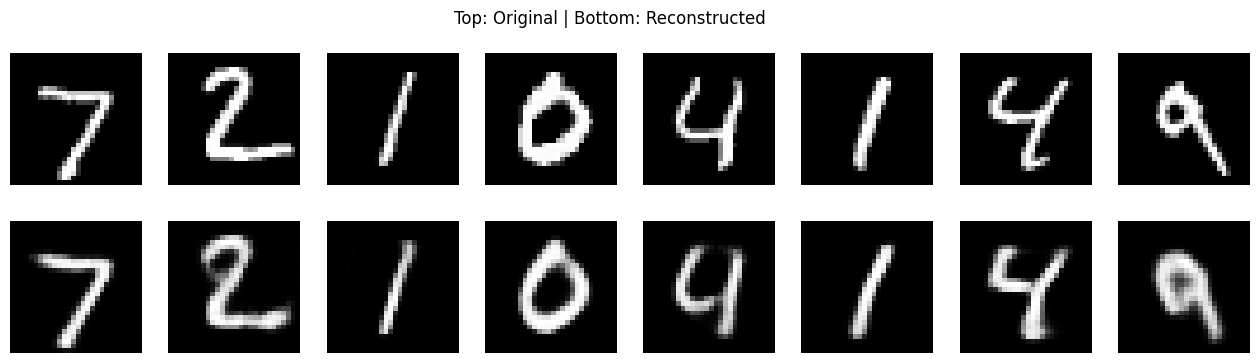

In [10]:
vae.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    x_hat, _, _ = vae(x)
    
    # 取前 8 张可视化
    x = x[:8].cpu()
    x_hat = x_hat[:8].cpu()
    
    plt.figure(figsize=(16,4))
    for i in range(8):
        # 原图
        plt.subplot(2,8,i+1)
        plt.imshow(x[i].squeeze(), cmap="gray")
        plt.axis('off')
        # 重建图
        plt.subplot(2,8,8+i+1)
        plt.imshow(x_hat[i].squeeze(), cmap="gray")
        plt.axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()


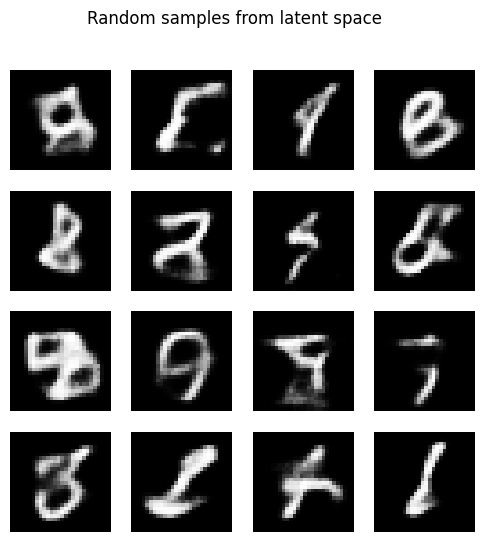

In [11]:
vae.eval()
with torch.no_grad():
    # 从标准正态采样
    z = torch.randn(16, 20).to(device)
    samples = vae.decode(z).cpu()
    
    plt.figure(figsize=(6,6))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(samples[i].squeeze(), cmap="gray")
        plt.axis('off')
    plt.suptitle("Random samples from latent space")
    plt.show()
